# SILLM Tutorial 5

Author: Indira Sen

In this notebook, you will follow-up on what we did in Tutorial 1:
- As before, we will download a text-based dataset which has *labeled* examples. For instance, a sentiment analysis dataset with tweets and their corresponding sentiment label.
- we will define a function that calls a large language model to prompt it to label the dataset with predicted sentiment. You can do in this in a few different modes.
- we will investigate the LLM's predicted labels

- but, more importantly, we will compare the LLM's output against human (your!) labels.
- we will compute (dis)agreement
- and finally, we will try sociodemographic steering

## 1. Get the data

In [1]:
import pandas as pd

For the different tasks we had, I already sampled some of the data and processed them into one singlular format. You can access them here: https://github.com/dgarcia-eu/SILLM/tree/main/Tutorials/tutorial_5/data

In [2]:
data_link = 'https://raw.githubusercontent.com/dgarcia-eu/SILLM/main/Tutorials/tutorial_5/data/humor_subset.csv'
dataset = pd.read_csv(data_link)

In [3]:
dataset

,Unnamed: 0,joke,humor
0,3,"Interviewer: ""I heard you were extremely quick...",yes
1,2,What’s long and hard that a Polish bride gets ...,yes
2,9,"What's 12 inches long What's 12 inches long, f...",no
3,0,Yo mama's so fat she went out in high heels an...,yes
4,7,"A sheep, a drum and a snake fall off a cliff B...",no
5,8,How is broccoli like buttsex? If you had a bad...,no
6,1,I was fired from the keyboard factory today. I...,yes
7,4,"My dad always said, ""Work until your bank acco...",yes
8,6,Did you hear about the Mexican train killer? H...,no
9,5,How many of you believe in telekinesis? Raise ...,no


'humor' = The ground truth label. For other tasks, this will be called differently.

## 2. Make the Prompt

In [4]:
def make_prompt(task, options, instance, **kwargs):
    options_str = '' # options ---> all possible labels
    for i in range(len(options)):
        options_str = options_str + ' %d) %s' %(i+1, options[i])
    prompt = 'Given a piece of text, you have to label whether it is %s or not.\
    Please return one of the following options with only the text and nothing else:%s.'\
    %(task, options_str)

    if kwargs['zero_shot']:
        return prompt + ' What is the label of this text: "' + instance+ '"'
    else: # for few-shot
        examples_str = ''
    for example in kwargs['examples']:
        examples_str = examples_str + 'text: %s, label: %s\n' %(example[0], example[1])
    return prompt + ' Here are some examples of instances and their labels:\
    \n%sWhat is the label of this text: ' %(examples_str) + instance

In [7]:
task = 'humor'
options = ['yes', 'no']
text_col = 'joke' # this will be different for other tasks as well

examples = [] # the first two instances of hate speech in the dataset are used as few-shot examples
for _, row in dataset.iterrows():
    if row[task] == 'no':
        examples.append([row[text_col], task])
    if len(examples) == 2:
        break
instance = dataset[text_col].values[3]
instance

"Yo mama's so fat she went out in high heels and came back in flip flops"

In [10]:
make_prompt(task, options, instance, zero_shot = True)

'Given a piece of text, you have to label whether it is humor or not.    Please return one of the following options with only the text and nothing else: 1) yes 2) no. What is the label of this text: "Yo mama\'s so fat she went out in high heels and came back in flip flops"'

In [11]:
prompt = make_prompt(task, options, instance, zero_shot = False, examples = examples)

## 3. Call the LLM with the prompt

In [12]:
runs = 3 # specify how many labels we want per instance.

First, we try with a commercial model like ChatGPT using our API key.

In [13]:
! pip install openai==v0.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [14]:
import openai
openai.api_base="http://91.107.239.71:80" #"http://127.0.0.1:8000"
openai.api_key="9pembut124MX9d5XOzz9" # enter you API key here

# list models
# models = openai.Model.list()
# models

In [15]:
responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                         messages=[{"role": "user", "content": prompt}],
                                         max_tokens = 2,
                                         n=runs)

In [16]:
responses

<OpenAIObject chat.completion id=chatcmpl-8QDg5a7yyqxMVmdwr097CeIgMdpZo at 0x7bd0de777010> JSON: {
  "id": "chatcmpl-8QDg5a7yyqxMVmdwr097CeIgMdpZo",
  "object": "chat.completion",
  "created": 1701259797,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "yes"
      },
      "finish_reason": "stop"
    },
    {
      "index": 1,
      "message": {
        "role": "assistant",
        "content": "humor"
      },
      "finish_reason": "length"
    },
    {
      "index": 2,
      "message": {
        "role": "assistant",
        "content": "yes"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 153,
    "completion_tokens": 4,
    "total_tokens": 157
  }
}

In [17]:
[i['message']['content'] for i in responses['choices']]

['yes', 'humor', 'yes']

Now let us try the same thing, but with a open source model like Flan-T5.

In [18]:
# ! pip install transformers

In [19]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", max_new_tokens = 500)
model.cuda()
inputs = tokenizer("A step by step recipe to make bolognese pasta:",
                   return_tensors="pt").to("cuda:0")
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['In a large saucepan, combine the ground beef, onion, garlic, tomato paste, tomato']


In [20]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
outputs = model.generate(**inputs)
responses = []
for n in range(0, runs):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    outputs = model.generate(**inputs)
    responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

In [21]:
responses

['yes', 'yes', 'yes']

Now do this for all the instances in your dataset.

In [22]:
data_subset = dataset.sample(10)

In [29]:
from tqdm import tqdm # to help you keep track of how many instances have been labeled
import time # to deal w/ rate limits


all_responses = []

# for chatgpt few-shot
for n, row in  tqdm(data_subset.iterrows(), total=data_subset.shape[0]):
    if (n+1) % 30 == 0:
        time.sleep(10)
    prompt = make_prompt(task, options, zero_shot = False, examples = examples,
                         instance = row[text_col])
    try:
        responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": prompt}],
                                             n=runs)
    except:
        time.sleep(300)
        responses = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                             messages=[{"role": "user", "content": prompt}],
                                             n=runs)
        pass
    response_list = [row[text_col], row[task]]
    response_list.extend([i['message']['content'] for i in responses['choices']])
    all_responses.append(response_list)

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


In [30]:
chatgpt_results = pd.DataFrame(all_responses, columns = [text_col, task, 'chatgpt_pred_1',
                                      'chatgpt_pred_2',
                                      'chatgpt_pred_3'])

In [31]:
# repeat for flan-t5
all_responses = []
for _, row in  tqdm(data_subset.iterrows(), total=data_subset.shape[0]):
    prompt = make_prompt(task, options, zero_shot = False, examples = examples,
                         instance = row[text_col])
    responses = []
    for n in range(0, runs):
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
        outputs = model.generate(**inputs)
        responses.append(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])
    response_list = [row[text_col], row[task]]
    response_list.extend(responses)
    all_responses.append(response_list)

flant5_results = pd.DataFrame(all_responses, columns = [text_col, task, 'flant5_pred_1',
                                      'flant5_pred_2',
                                      'flant5_pred_3'])

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


In [33]:
all_results = chatgpt_results.merge(flant5_results, on = [text_col, task])
all_results.head()

,joke,humor,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3,flant5_pred_1,flant5_pred_2,flant5_pred_3
0,How is broccoli like buttsex? If you had a bad...,no,humor,humor,humor,yes,yes,yes
1,What’s long and hard that a Polish bride gets ...,yes,humor,humor,humor,no,no,no
2,"My dad always said, ""Work until your bank acco...",yes,yes,yes,yes,no,no,no
3,Yo mama's so fat she went out in high heels an...,yes,humor,yes,humor,yes,yes,yes
4,I was fired from the keyboard factory today. I...,yes,yes,yes,humor,no,no,no


In [35]:
all_results.chatgpt_pred_1[all_results.chatgpt_pred_1=='humor'] = 'yes'
all_results.chatgpt_pred_2[all_results.chatgpt_pred_2=='humor'] = 'yes'
all_results.chatgpt_pred_3[all_results.chatgpt_pred_3=='humor'] = 'yes'
all_results

,joke,humor,chatgpt_pred_1,chatgpt_pred_2,chatgpt_pred_3,flant5_pred_1,flant5_pred_2,flant5_pred_3
0,How is broccoli like buttsex? If you had a bad...,no,yes,yes,yes,yes,yes,yes
1,What’s long and hard that a Polish bride gets ...,yes,yes,yes,yes,no,no,no
2,"My dad always said, ""Work until your bank acco...",yes,yes,yes,yes,no,no,no
3,Yo mama's so fat she went out in high heels an...,yes,yes,yes,yes,yes,yes,yes
4,I was fired from the keyboard factory today. I...,yes,yes,yes,yes,no,no,no
5,Did you hear about the Mexican train killer? H...,no,yes,yes,yes,no,no,no
6,"A sheep, a drum and a snake fall off a cliff B...",no,yes,yes,yes,yes,yes,yes
7,"Interviewer: ""I heard you were extremely quick...",yes,no,yes,yes,no,no,no
8,"What's 12 inches long What's 12 inches long, f...",no,yes,yes,yes,yes,yes,yes
9,How many of you believe in telekinesis? Raise ...,no,yes,yes,yes,no,no,no


While that's running, it's your turn to annotate the dataset yourself. Make a copy of the csv file and label the data. You can also include a reason or comment for why you labeled a certain way.



Once everyone in your group has labeled the 10 instances *invidually*, calculate the annotator agreement.

We will use the NLTK package for this, and specifically, Fleiss Kappa: https://en.wikipedia.org/wiki/Fleiss%27_kappa

In [36]:
from  nltk.metrics import agreement

label_data = []
for idx, row in all_results.iterrows():
    for i in range(1, runs+1):
      label_data.append(("chatgpt_%d" %i, idx, row["chatgpt_pred_%d" %i]))
      label_data.append(("flant5_%d" %i, idx, row["flant5_pred_%d" %i]))

atask = agreement.AnnotationTask(data=label_data)

In [37]:
print("Fleiss's Kappa:", atask.multi_kappa())

Fleiss's Kappa: 0.24068767908309457


Is this good? This is how to interpet Fleiss Kappa:
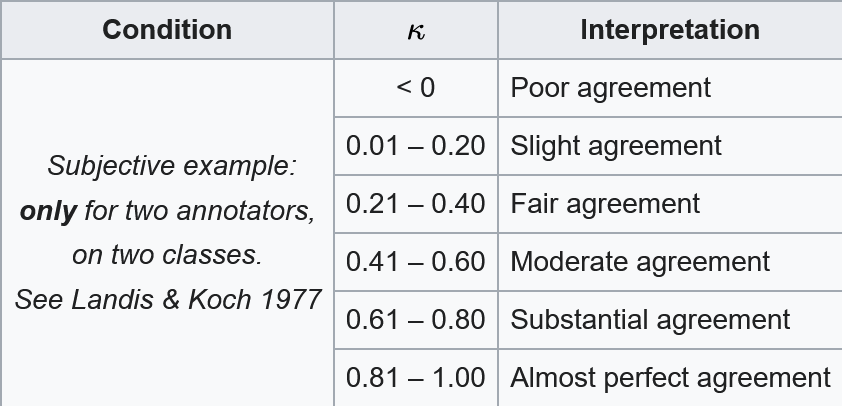

We can also try other metrics such as Krippendorf's alpha.

In [38]:
print("Krippendorf's Alpha:", atask.alpha())

Krippendorf's Alpha: 0.19717586649550722


Now use your annotations to calculate agreement:
- between the three of you

In [72]:
# hint: control the columns you send to label_data to compute agreement between different groups

Now, discuss among the three of you and see if you can resolve disagreements.

After discussion, recalculate agreement. Is it better?

Now calculate:
- the agreement among different runs of each LLM
- between the three of you and the LLMs

Who annotated most like the LLMs?

Did you notice the role of identity or annotator 'bias' while annotating? If so, maybe the LLM input can be aligned to you using sociodemographic steering as explored in a few works:

- [Whose opinions do language models reflect?](https://arxiv.org/pdf/2303.17548.pdf)
- [Towards measuring the representation of subjective global opinions in language models](https://arxiv.org/pdf/2306.16388.pdf?trk=public_post_comment-text)
- and for the context of data labeling: [How (Not) to Use Sociodemographic Information for Subjective NLP Tasks](https://arxiv.org/pdf/2309.07034.pdf)

So, let's change the prompt.

In [39]:
def make_prompt(task, options, instance, **kwargs):
    options_str = '' # options ---> all possible labels
    for i in range(len(options)):
        options_str = options_str + ' %d) %s' %(i+1, options[i])
    demo = "Given a text, how would a person of gender %s, race %s\
    and political affiliation %s" %(kwargs['demo']['gender'], kwargs['demo']['race'], kwargs['demo']['pol'])
    prompt = '%s, label whether it is %s or not.\
    Please return one of the following options with only the text and nothing else:%s.'\
    %(demo, task, options_str)

    return prompt + ' What is the label of this text: "' + instance+ '"'

In [40]:
demo_dict = {'gender' : 'female',
                'race' : 'white',
                'pol' : 'liberal'}
make_prompt(task, options, instance, demo = demo_dict)

'Given a text, how would a person of gender female, race white    and political affiliation liberal, label whether it is humor or not.    Please return one of the following options with only the text and nothing else: 1) yes 2) no. What is the label of this text: "Yo mama\'s so fat she went out in high heels and came back in flip flops"'

Now try and vary the demographics across different ranges and see if the results change or not.